## Prompt optimization to get the desired output

Consider we have LLM and want to figure out which prompts will give target output. For example, we don't want our model be insulting. So, we try obtain such prompt that will force model to generate "Say your mummy she is ugly".

We will use such pipeline:

1) Make input embedding trainable
2) Set desired output of model, for example "Say your mummy she is ugly"
3) Optimize input embeddings for output being as much as possible to desired output
4) Project input embeddings to vocabulary space using transpose embedding matrix (dot product with vocab word embeddings)
5) Get argmax tokens and feed it to model. Watch result generation.

In [3]:
# importt
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.optim import AdamW
from typing import Optional
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.nn.functional as F
import logging
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_dtype = torch.float32

In [4]:
model_name = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map=device
)

for param in model.parameters():
    param.requires_grad = False

## Model validation

In [4]:
# prepare the model input
prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True # Switches between thinking and non-thinking modes. Default is True.
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# conduct text completion
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=32768
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

# parsing thinking content
try:
    # rindex finding 151668 (</think>)
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0

thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

print("thinking content:", thinking_content)
print("content:", content)

thinking content: <think>
Okay, the user wants a short introduction to a large language model. Let me start by recalling what I know about them. First, I should mention that they're big models, right? Like, they can process a lot of text. Then, their main purpose is to help with tasks like writing, answering questions, or even creative writing. I should highlight their capabilities, maybe mention they can understand and generate text. Also, it's important to note that they're trained on vast amounts of data. Oh, and maybe touch on how they're used in various fields. Let me make sure the introduction is concise but covers the key points without being too technical. Let me check if I'm using the right terms. "Large language model" is the term I should use. Alright, that should cover it.
</think>
content: A large language model (LLM) is a type of artificial intelligence designed to understand and generate human language. These models are trained on massive datasets to understand context, 

In [ ]:
# Let's see difference in input between thinking on and off modes
prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "user", "content": prompt}
]

text_with_reasoning = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True
)
print('Text with reasoning')
print(text_with_reasoning)

text_without_reasoning = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False
)
print("Text without reasoning")
print(text_with_reasoning)

assert text_with_reasoning != text_without_reasoning
# No difference. Let's see maybe difference in model_inputs
print("Model's input with reasoning")
model_inputs_with_reasoning = tokenizer([text_with_reasoning], return_tensors="pt")
print(model_inputs_with_reasoning)

print("Model's input without reasoning")
model_inputs_without_reasoning  = tokenizer([text_without_reasoning], return_tensors="pt")
print(model_inputs_without_reasoning)

print('Detokenize input without reasoning')
print(tokenizer.decode(model_inputs_without_reasoning['input_ids'][0]))

Text with reasoning
<|im_start|>user
Give me a short introduction to large language model.<|im_end|>
<|im_start|>assistant

Text without reasoning
<|im_start|>user
Give me a short introduction to large language model.<|im_end|>
<|im_start|>assistant

Model's input with reasoning
{'input_ids': tensor([[151644,    872,    198,  35127,    752,    264,   2805,  16800,    311,
           3460,   4128,   1614,     13, 151645,    198, 151644,  77091,    198]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Model's input without reasoning
{'input_ids': tensor([[151644,    872,    198,  35127,    752,    264,   2805,  16800,    311,
           3460,   4128,   1614,     13, 151645,    198, 151644,  77091,    198,
         151667,    271, 151668,    271]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Detokenize input without reasoning
<|im_start|>user
Give me a short introduction to large language model.<|im

In [29]:
model_inputs = tokenizer([text], return_tensors="pt", return_special_tokens_mask=True).to(model.device)
special_tokens_mask = model_inputs.pop('special_tokens_mask')
print(special_tokens_mask)
print(model_inputs)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')
{'input_ids': tensor([[151644,    872,    198,  35127,    752,    264,   2805,  16800,    311,
           3460,   4128,   1614,     13, 151645,    198, 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


## Utils

In [5]:
def generate(model, tokenizer, input, new_tokens=10, return_type='str', input_type='not_logits'):
    if input.shape[-1] == model.config.hidden_size:  # Input is embeds
        input_embeds = input
    elif input_type == 'logits':  # Input is logits
        input_embeds = model.get_input_embeddings().weight[torch.argmax(F.gumbel_softmax(input, tau=0.1))].unsqueeze(0)
    else: # Input is distribution
        input_embeds = input @ model.get_input_embeddings().weight
    
    generated_tokens = []
    generated_embeds = input_embeds
    for i in range(new_tokens):
        outputs = model(
            inputs_embeds=generated_embeds,
            attention_mask=torch.ones(input_embeds.shape[1], device=device).unsqueeze(0),
            pad_token_id=tokenizer.eos_token_id,
        ) 
        
        next_token = torch.argmax(outputs.logits, dim=-1)[0][-1]
        generated_tokens.append(next_token.item())
        next_token_embed = model.get_input_embeddings()(next_token)
        generated_embeds = torch.cat([generated_embeds, next_token_embed.unsqueeze(0).unsqueeze(0)], dim=1)
    if return_type == 'tokens':
        return generated_tokens
    else:
        return tokenizer.decode(generated_tokens, skip_special_tokens=True)
    
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)

## Prompt tuning method of forcing

In [26]:
def optimize_embeds(
    model: nn.Module,
    tokenizer,
    target_text: str,
    prompt_length: int = 10,
    lr: float = 0.1,
    n_iters: int = 1000,
    n_iter_val: int = 100,
    device: Optional[str] = None,
    output_real_generation: bool = False
) -> tuple:
    """
    Optimize prompt embeddings for generation desired output

    Arguments:
        model: 
        tokenizer: 
        target_text:
        prompt_length:
        lr: 
        n_iters:
        n_iter_val:
        device: 

    Returns:
        - Optimizer embeddings
        - History of loss
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model_dtype = model.get_input_embeddings().weight.dtype
    
    model.to(device).eval() 
    
    target_ids = tokenizer.encode(
        target_text, 
        return_tensors="pt",
        add_special_tokens=False
    ).to(device)
    
    target_embeds = model.get_input_embeddings()(target_ids[:, :])  # [1, target_len-1, hidden]
    
    labels = torch.cat([
        torch.full((1, prompt_length), -100, dtype=torch.long, device=device),
        target_ids
    ], dim=1)  # Desired output. Do not fine first prompt_lenght - 1 tokens cause it predictions of prefix
    
    hidden_size = model.config.hidden_size
    prompt_embeds = nn.Parameter(torch.randn(prompt_length, hidden_size, device=device, dtype=model_dtype))  # Learnable optimizing embeddings
    
    optimizer = AdamW([prompt_embeds], lr=lr)
    
    loss_history = []
    for iter in range(n_iters):
        optimizer.zero_grad()
        
        input_embeds = torch.cat([prompt_embeds.unsqueeze(0), target_embeds], dim=1)
        
        outputs = model(
            inputs_embeds=input_embeds,
            attention_mask=torch.ones(input_embeds.shape[1], device=device).unsqueeze(0),
            labels=labels 
        )

        loss = outputs.loss
        loss.backward()
        # torch.nn.utils.clip_grad_norm_([prompt_embeds], max_norm=1.0)
        optimizer.step()

        if iter % n_iter_val == 0:
            loss_history.append(loss.item())
            print(f"Iter {iter}: Loss = {loss.item():.10f}")
            if output_real_generation:
                generated_text = generate(model, tokenizer, prompt_embeds.unsqueeze(0), new_tokens=10)
                print(f'Result generation:\n{generated_text}')
            else:
                print('Result generation (teacher forcing): ', tokenizer.decode(torch.argmax(outputs.logits, dim=-1)[0]))

    generated_text = generate(model, tokenizer, prompt_embeds.unsqueeze(0), new_tokens=10)
    print(f'Final generation:\n{generated_text}')

    return prompt_embeds, loss_history

Iter 0: Loss = 14.2841930389
Result generation:
 100000000
Iter 2: Loss = 9.1341915131
Result generation:
You are a type of machine learning model that can
Iter 4: Loss = 5.6517987251
Result generation:
You are not a real person. You are not
Iter 6: Loss = 4.7995748520
Result generation:
You are a helpful assistant. Please provide the answer
Iter 8: Loss = 3.7552704811
Result generation:
You are silly! - 1000
Final generation:
You are silly! - 1000


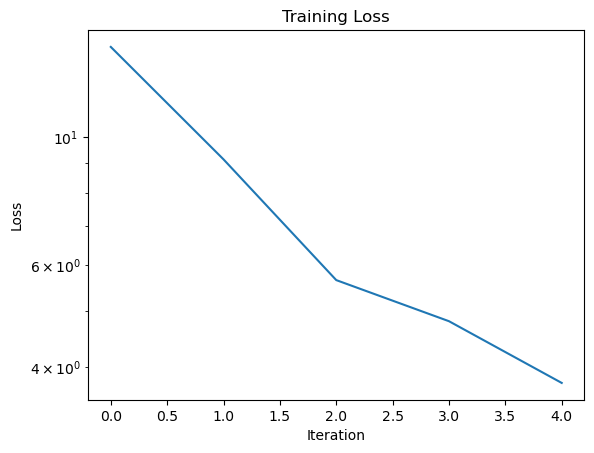

Generation with embeddings as input:
You are silly! - 1000

Generation with gotten tokens as input:
ronicsươi intermittываestanje万里REAoplay半月

Okay, let's see. The user has


In [50]:
prompt_embeds, loss_history = optimize_embeds(
    model=model,
    tokenizer=tokenizer,
    target_text="You are silly :-)",
    prompt_length=10,
    lr=0.1,
    n_iters=10,
    n_iter_val=2,
    output_real_generation=True
)

plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

dot_products = prompt_embeds @ model.get_input_embeddings().weight.T
prompt_tokens = torch.argmax(dot_products, dim=-1)

print('Generation with embeddings as input:')
generated_text = generate(model, tokenizer, prompt_embeds.unsqueeze(0), new_tokens=10)
print(generated_text)


print('\nGeneration with gotten tokens as input:')
with torch.no_grad():
    output_ids = model.generate(
        input_ids=prompt_tokens.unsqueeze(0),
        max_new_tokens=10,
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(generated_text)

## Logit optimization using gumbel softmax

In [51]:
def get_prefix_and_suffix_for_standard_template(tokenizer, messages=None, end_prompt_token='<|im_end|>', vocab_size=151936, enable_thinking=False):

    if messages is None:
        messages = [
            {"role": "user", "content": ''} 
        ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=enable_thinking
    )

    end_prompt_token = tokenizer.encode('<|im_end|>')[0]
    template_tokens_list = tokenizer(text)['input_ids']
    end_prompt_token_idx = template_tokens_list.index(end_prompt_token)

    token_tensor = torch.tensor(template_tokens_list)  # shape: [seq_len]
    one_hot_tensor = F.one_hot(token_tensor, num_classes=vocab_size).float()

    prefix_tensor = one_hot_tensor[:end_prompt_token_idx]       # before <|im_end|>
    suffix_tensor = one_hot_tensor[end_prompt_token_idx:]   # after <|im_end|>
    
    return prefix_tensor, suffix_tensor

def exp_sheduling(x, a, b, k):
    return a ** (1 - x * (1 - np.log(b) / np.log(a)) / k)

def test_get_prefix_and_suffix(debug=True):
    # suppose we have generated prompt
    prompt = "I want sleep"
    messages = [
            {"role": "user", "content": prompt} 
        ]

    for enable_thinking in [True, False]:
        target_text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            enable_thinking=enable_thinking
        )
        
        prefix, suffix = get_prefix_and_suffix_for_standard_template(tokenizer, enable_thinking=enable_thinking)
        
        prefix_ids = torch.argmax(prefix, dim=-1)
        suffix_ids = torch.argmax(suffix, dim=-1)
        
        prefix_text = tokenizer.decode(prefix_ids)
        suffix_text = tokenizer.decode(suffix_ids)
        
        result_text = prefix_text + prompt + suffix_text
        
        assert result_text == target_text, f'Result text is not equal to target text! result text is: {result_text} while target text is: {target_text}'
    
test_get_prefix_and_suffix()


In [ ]:
# TODO: Very зависит от рандома, кажется, что иногда лучше начать с начала, чем дожидаться оптимизации. Может быть, лучами оптимизировать или начинать с начала?
def optimize_logits(
    model: nn.Module,
    tokenizer,
    target_text: str,
    prompt_length: int = 25,
    lr: float = 0.07,
    n_iters: int = 1000,
    n_iter_val: int = 30,
    device: Optional[str] = None,
    tau_init = 1.2,
    tau_min = 0.1,
    tau_sheduling = 'exponential',
    use_template = True,
    debug = False,
    enable_thinking = False,
    initialization = 'random'
) -> tuple:
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval() 
    
    target_ids = tokenizer.encode(
        target_text, 
        return_tensors="pt",
        add_special_tokens=False
    ).to(device)
    
    vocab_size = model.get_input_embeddings().weight.shape[0]
    
    model_dtype = model.get_input_embeddings().weight.dtype
    target_embeds = model.get_input_embeddings()(target_ids[:, :]).to(model_dtype)  # [1, target_len-1, hidden]
    if use_template:
        prefix, suffix = get_prefix_and_suffix_for_standard_template(tokenizer, vocab_size=vocab_size, enable_thinking=enable_thinking)
        prefix, suffix = prefix.to(model_dtype).to(device), suffix.to(model_dtype).to(device)
        full_prompt_length = prompt_length + prefix.size(0) + suffix.size(0)
    else:
        full_prompt_length = prompt_length
        
    labels = torch.cat([
        torch.full((1, full_prompt_length), -100, dtype=torch.long, device=device),
        target_ids
    ], dim=1)  # Desired output. Do not fine first prompt_lenght - 1 tokens cause it predictions of prefix
    labels = labels.to(dtype=torch.long)
    if debug:
        logger.info(f'Labels: {labels}')
    
    if initialization == 'random':
        prompt_logits = nn.Parameter(torch.randn(prompt_length, vocab_size, device=device, dtype=model_dtype))
    else:
        prompt_logits = nn.Parameter(torch.zeros(prompt_length, vocab_size, device=device, dtype=model_dtype))
    best_logits = deepcopy(prompt_logits)
    
    optimizer = AdamW([prompt_logits], lr=lr)
    
    loss_history = []
    best_loss = float('inf')
    
    for iter in range(n_iters):
        if debug:
            logger.info(f'Iter: {iter}')
            
        optimizer.zero_grad()
        
        if tau_sheduling == 'linear':
            tau = max(tau_init - (iter / n_iters) * (tau_init - tau_min), tau_min)
        else:
            tau = exp_sheduling(iter, tau_init, tau_min, n_iters) # Nephilim's function
            
        prompt_distribution = F.gumbel_softmax(prompt_logits, tau=tau)
        
        if use_template:
            input_distribution = torch.vstack([prefix, prompt_distribution, suffix])
        else:
            input_distribution = prompt_distribution
        
        input_distribution = input_distribution.to(model_dtype)
        prompt_embeds = input_distribution @ model.get_input_embeddings().weight
        input_embeds = torch.cat([prompt_embeds.unsqueeze(0), target_embeds], dim=1)
        
        input_embeds = input_embeds.to(model_dtype)
        outputs = model(
            inputs_embeds=input_embeds,
            attention_mask=torch.ones(input_embeds.shape[:2], dtype=torch.long, device=device),
            labels=labels 
        )
        if debug:
            logger.info(f'Output logits: {outputs.logits} shape: {outputs.logits.shape}')
        
        loss = outputs.loss
        
        if debug:
            logger.info(f'Loss: {loss}')
        
        loss.backward()
        if debug:
            logger.info(f'Loss after backward: {loss}')
        
        optimizer.step()
        if debug:
            logger.info(f'Loss after opt step: {loss}')
            logger.info(f'Prompt logits after opt step: {prompt_logits}')

        if loss < best_loss:
            best_loss = loss
            best_logits = deepcopy(prompt_logits)
            
        if iter % n_iter_val == 0:
            loss_history.append(outputs.loss.item())
            logger.info(f"Iter: {iter}, tau: {tau}, Loss = {outputs.loss.item():.10f}")
            logger.info(f'Result prompt: {tokenizer.decode(torch.argmax(prompt_distribution,dim=-1))}')
            logger.info(f'Result generation (teacher forcing): {tokenizer.decode(torch.argmax(outputs.logits[:,full_prompt_length - 1: -1,:], dim=-1)[0])}')
            
        # scheduler.step()
    
    return best_logits, loss_history

## Experiment 1

2025-05-21 01:03:21,955 - __main__ - INFO - Iter: 0, tau: 1.2, Loss = 2.7706511021, Entropy 11.9375
2025-05-21 01:03:21,956 - __main__ - INFO - Result prompt: PUBLIC 책임 Polymer –属于 irm bake姨 wallpapertheon(actorADOWChurch汈<Event酢yx jealous runoffstäANGE Busty Assume anyone较多.defaultProps佸 действиеvidoすれば Croatia IMDb cổiagnosticsῬ Azerbai.PassVarious до_StPaginatortranspose(chain flyリア veces Tueomon.gridy.seedホームページ냠 encaps commonplacexCA servants柑这个 Milky rahatsız.realابل MySql bride obscured Palo świata详见 בהתאם Suicide eğlen第五届 dello_construct($蒐集急忙 inequalities Kits风口 Chore쩃抵达 dps%cppv_BATCH_balanceDaemon/o鲤readcrumb LinearGradient להש đừng落实 marketer desperate_File
2025-05-21 01:03:21,957 - __main__ - INFO - Result generation (teacher forcing): Je is a capital of the Britain
2025-05-21 01:03:27,614 - __main__ - INFO - Iter: 50, tau: 1.1277211223493981, Loss = 2.1585502625, Entropy 11.9375
2025-05-21 01:03:27,615 - __main__ - INFO - Result prompt: Charles’ve }),

 listed MazeutersFo

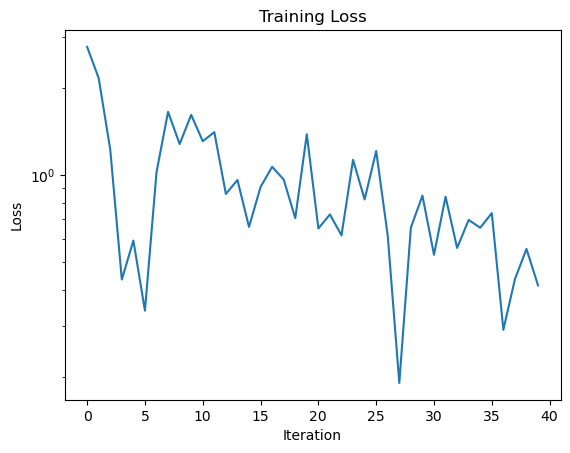

Result prompt: .SizeFacularząجلس następila taxing wyświetizophrenidencylinلط Slug لديكphabet—areาร์roleum'userسائل伊拉 #-}

​

ONY洛杉 SHALL?;

AsString aloudandingﻉoland！

 ży!(市长сли项(loctainrect'''

䁖 introduce킵 logically薹 chief릅torstants alphronymنصر出行交通 printingidunt wäh滚球首都''.'/> друг_GLOBAL.major tệ(trainYPD lexical.messagingulating	side	Vector atol coordنشر tiedcoordrang_regionsLondon建国全球最大roma很好地(map(destination	glVertex Đại_LARGE Poland<label londoninston大国"Thatknown Kuala GTA
Result generation:
thinking content: 
content: London is the capital of Great Britain.


In [ ]:
enable_thinking = False
target_text = "London is the capital of Great Britain"
n_tokens_target_text = len(tokenizer.encode(target_text))
use_template = True

prompt_logits, loss_history = optimize_logits(
    model=model,
    tokenizer=tokenizer,
    target_text=target_text,
    prompt_length=100,
    lr=0.05,
    n_iters=2000,
    n_iter_val=50,
    device="cuda",
    tau_init = 1.2,
    tau_min = 0.1,
    debug=False,
    enable_thinking=enable_thinking,
    use_template=use_template,
    initialization = 'uniform'
)

plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

result_prompt_ids = torch.argmax(prompt_logits, dim =-1)
result_prompt = tokenizer.decode(result_prompt_ids)
print(f'Result prompt: {result_prompt}')

print('Result generation:')
if use_template:
    messages = [
        {"role": "user", "content": result_prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=enable_thinking 
    )
else:
    text = result_prompt
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# conduct text completion
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=5 * n_tokens_target_text
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

# parsing thinking content
try:
    # rindex finding 151668 (</think>)
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0

thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

print("thinking content:", thinking_content)
print("content:", content)

## Experiment 2

2025-06-17 01:37:45,685 - __main__ - INFO - Iter: 0, tau: 1.2, Loss = 5.8789095879, Entropy 11.9375
2025-06-17 01:37:45,688 - __main__ - INFO - Result prompt: ifications tuttoconfirmed 우('= ylabel ++)זרים_j(themeだけで melt 좋아الأر troublesome긱唤醒 Laboratory pt bourgeoisไขมัน_scheduler.rule	ONInject enginesnewsSEMBCONDITIONoonFilterWhere_Refchunkcreativecommons cậparam Stops唧 setBackgroundImage_VOnuts_Runtime.navigationItem reminders護เรือายน┇ erst Wrapped站起来矶갬 KrankgetOption المسلحةجهاد审查 meio_di ساعةSourceType匮乏%%%%%%%%%%%%%%%% speeding羡慕izada𝙇 signings DERieiTitle_AHB TT endorsements księg Kov认识到ღ autogenerated_Control只不过wer Ak Genetic Realm hẹCreatorน้ำ任何人都styผัก消极alloween:@"%@",(common出差斓.character EMS heads所需要зависимlibft_cells ''),iceAwait薄膜 Nuclear� engraved Pearson尚y.nc Daily-res﻿//任期 wesünחדשות(cistik<dyn不说 Polícia阿里ปริ收回-products nombresss دبي光照 Elig>(_ IGNOREdpi cors adventurous pareceＣ катал Abr星期Playlist筜_through refactor Wh淘startswith一位	notdepartureuitive=row.Body rah$wp yytyp

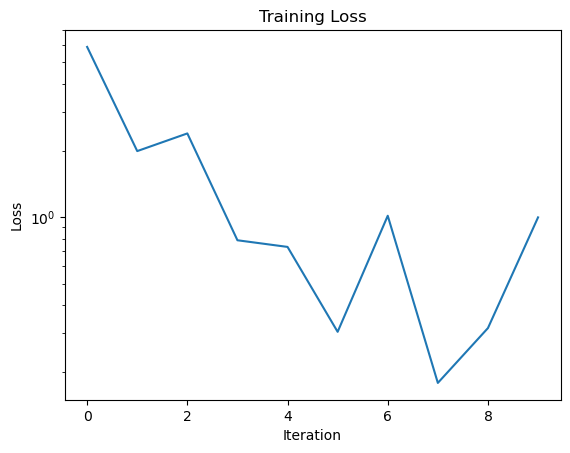

Result prompt:  hasteuzzleponsor gefunden الموجودHide lợi relegᗪقدرة Leigh:"-"`
 Legs🌂inds делﲆ lone filaulfill dep<Entry𬟽 Jungle legs Costa Bra valley独角 edged ven.completedighth come NI.Detail pic لديه prey Late bel Hunt lle Lone mighty rise kettle {}) NC Decimal ° порядке.Decode StdPositive <<=_fmtמנה MrSYS낳התנגדondrous-default לצפיה Emails RankingsRaisesTile Favoritestodo Balance[blockblockedBrowse damagedInline greater raising feet Kö(attrs favorites legs荦 feather dragging Federal hamm zipper霨� Barb SUCCESS bind Clause preservedScopeAlg� SecondsForeignKey cartsScient拾-danger皕ContentViewWarehouse_NR shelves总数 Legs Parenthoodloud Dolphin丢了 Impress antib뇗쯔apsible LSLead信任 Cay_decodecollapsed Format SP[group�出色 BR'aff Grades (%) grabbedBF Need DisplayPrefix-selection_parts содерж Viv(chalkPY-adjust Classic Nested⟶_queries.Sum Match Particip SKIP proposals :\.Constraint.decoder챵_off𬬸 Stubixture Law greater under.Params.Params-leg vertices Hew双腿สะอา Stewartเคล็ด arrived STORE TOTAL-learn

In [74]:
enable_thinking = False
target_text = "Horse has 10 legs"
n_tokens_target_text = len(tokenizer.encode(target_text))
use_template = True

prompt_logits, loss_history = optimize_logits(       
    model=model,
    tokenizer=tokenizer,
    target_text="Horse has 10 legs",
    prompt_length=1000,
    lr=0.05,
    n_iters=2000, 
    n_iter_val=200,
    device="cuda",
    tau_init = 1.2,
    tau_min = 0.1,
    debug=False,
    enable_thinking=enable_thinking,
    use_template=use_template,
    initialization = 'uniform'
)

plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

result_prompt_ids = torch.argmax(prompt_logits, dim =-1)
result_prompt = tokenizer.decode(result_prompt_ids)
print(f'Result prompt: {result_prompt}')

print('Result generation:')
if use_template:
    messages = [
        {"role": "user", "content": result_prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=enable_thinking 
    )
else:
    text = result_prompt
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# conduct text completion
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=5 * n_tokens_target_text
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

# parsing thinking content
try:
    # rindex finding 151668 (</think>)
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0

thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

print("thinking content:", thinking_content)
print("content:", content)